In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random
from torch.nn import functional as F

In [2]:
os.chdir("/home/atul/diffusion-based-environment-generator/generator")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [3]:
from maze.grid_world_generator import generate_multiple_grid_worlds
from maze.solvers.a_star_l2 import main

generate_multiple_grid_worlds(10_000, 10)
main() # main function of a_star


./data/grid/


Processing Mazes: 100%|██████████| 10000/10000 [00:03<00:00, 2707.52maze/s]


In [4]:
class GridWorldDataset(Dataset):
    def __init__(self, directory):
        # print(directory)
        self.files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # print(self.files[idx])
        grid = np.load(self.files[idx])
        return torch.tensor(grid, dtype=torch.int32)

In [5]:
def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    # Below is ChatGPT   
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([0, 0, 1])  # Source → Blue
    img[destination] = np.array([0, 1, 0])  # Destination → Green
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
dataset = GridWorldDataset("/home/atul/diffusion-based-environment-generator/generator/data/grid")

In [7]:
def display_grid_text(grid):
    """
    Displays the grid world in text format.
    """
    height, width = grid.shape[1], grid.shape[2]
    char_grid = np.full((height, width), '-', dtype=str)
    
    wall = grid[:, :, 0] == 0
    source = grid[:, :, 1] == 1
    destination = grid[:, :, 2] == 1
    
    char_grid = np.full(wall.shape, '-', dtype=str)  # Default to empty space
    char_grid[wall] = '#'  # Walls
    char_grid[source] = 'S'  # Source
    char_grid[destination] = 'E'  # Destination
    
    print("\n".join("".join(row) for row in char_grid))

In [8]:
print(dataset[0].shape)

torch.Size([10, 10, 3])


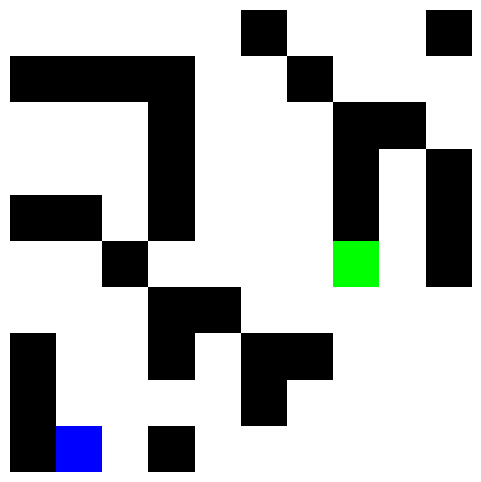

In [9]:
plot_grid_world(dataset[0])

In [10]:
display_grid_text(dataset[0])

-----#---#
####--#---
---#---##-
---#---#-#
##-#---#-#
--#----E-#
---##-----
#--#-##---
#----#----
#S-#------


In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [12]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/atul/diffusion-based-environment-generator/generator


In [13]:
# Modify sigmoid layer for sharper output
class SharpSigmoid(nn.Module):
    def __init__(self, sharpness_factor=5.0):
        super(SharpSigmoid, self).__init__()
        self.sharpness_factor = sharpness_factor

    def forward(self, x):
        return torch.sigmoid(self.sharpness_factor * x)


class RandomSignFlip(nn.Module):
    def __init__(self, flip_prob=0.01):
        super(RandomSignFlip, self).__init__()
        self.flip_prob = flip_prob
        
    def forward(self, x):
        # Generate a mask with 20% probability of flipping the sign
        flip_mask = torch.rand(x.shape, device=x.device) < self.flip_prob  # 20% chance to flip
        sign_flip = torch.where(flip_mask, torch.tensor(-1.0, device=x.device), torch.tensor(1.0, device=x.device))
        return x * sign_flip  # Apply random sign flip based on the mask

class Scale(nn.Module):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        return x * self.factor


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MazeVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(MazeVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(300, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Linear(256, 300),
            # RandomSignFlip(),
            nn.Tanh(),
            Scale(4),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = x.view(x.size(0), -1)  # flatten: (B, 300)
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        out = self.decoder(z)
        return out.view(-1, 10, 10, 3)  # reshape to (B, 10, 10, 3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

    def predict_discrete_structure(self, recon_batch):
        """
        Converts real-valued (B, 10, 10, 3) output into integer maze tensor.
        - Channel 0: binary walls
        - Channel 1: one-hot source
        - Channel 2: one-hot destination
        """
        B = recon_batch.shape[0]

        print(recon_batch[..., 0])

        wall = (recon_batch[..., 0] >= 0.5).int()

        print("WALL")
        print(wall)

        source_flat = recon_batch[..., 1].view(B, -1)
        source_indices = source_flat.argmax(dim=1)
        source_onehot = torch.zeros_like(source_flat, dtype=torch.int)
        source_onehot[torch.arange(B), source_indices] = 1
        source_onehot = source_onehot.view(B, 10, 10)

        dest_flat = recon_batch[..., 2].view(B, -1)
        dest_indices = dest_flat.argmax(dim=1)
        dest_onehot = torch.zeros_like(dest_flat, dtype=torch.int)
        dest_onehot[torch.arange(B), dest_indices] = 1
        dest_onehot = dest_onehot.view(B, 10, 10)

        result = torch.stack([wall, source_onehot, dest_onehot], dim=-1).int()
        return result


In [15]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 100
LATENT_DIM = 128

In [16]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Training dataset size: {len(dataset)}')

Training dataset size: 10000


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vae = MazeVAE(latent_dim=LATENT_DIM)
optimizer = optim.Adam(list(vae.parameters()), lr=LEARNING_RATE)

cuda


In [18]:
def connectivity_loss(recon_x, max_dist=100.0):
    """
    recon_x: [B, H, W, 3] – output from decoder after sigmoid
    """
    wall_prob = recon_x[..., 0]         # [B, H, W]
    source_prob = recon_x[..., 1]       # [B, H, W]
    dest_prob = recon_x[..., 2]         # [B, H, W]
    
    traversable = 1.0 - wall_prob       # higher means more walkable
    B, H, W = traversable.shape

    # Soft-argmax to get source & destination coordinates
    grid_y, grid_x = torch.meshgrid(
        torch.linspace(0, 1, H, device=recon_x.device),
        torch.linspace(0, 1, W, device=recon_x.device),
        indexing='ij'
    )  # both [H, W]

    grid_x = grid_x.unsqueeze(0)  # [1, H, W]
    grid_y = grid_y.unsqueeze(0)

    # Normalize source/dest masks
    source_prob = source_prob / (source_prob.sum(dim=(1,2), keepdim=True) + 1e-8)
    dest_prob = dest_prob / (dest_prob.sum(dim=(1,2), keepdim=True) + 1e-8)

    # Compute soft coordinates
    src_x = (grid_x * source_prob).sum(dim=(1,2))
    src_y = (grid_y * source_prob).sum(dim=(1,2))
    dst_x = (grid_x * dest_prob).sum(dim=(1,2))
    dst_y = (grid_y * dest_prob).sum(dim=(1,2))

    # Compute squared distance (proxy for disconnected if very large)
    dist_sq = (src_x - dst_x)**2 + (src_y - dst_y)**2  # [B]

    # Invert: higher dist → higher loss
    loss = dist_sq / (max_dist ** 2)
    return loss.mean()


In [ ]:
def compute_q_error(x, recon_x):
    # Extract one-hot source/destination
    src_true = (x[..., 1] == x[..., 1].amax(dim=(1, 2), keepdim=True)).float()
    dst_true = (x[..., 2] == x[..., 2].amax(dim=(1, 2), keepdim=True)).float()
    
    src_pred = (recon_x[..., 1] == recon_x[..., 1].amax(dim=(1, 2), keepdim=True)).float()
    dst_pred = (recon_x[..., 2] == recon_x[..., 2].amax(dim=(1, 2), keepdim=True)).float()
    
    # Get (x, y) positions: shape [B, 2]
    def get_coords(mask):
        B = mask.shape[0]
        H, W = mask.shape[1:3]
        flat = mask.view(B, -1)  # [B, H*W]
        idx = flat.argmax(dim=1)  # [B]
        x = idx // W
        y = idx % W
        return torch.stack((x, y), dim=1)  # [B, 2]

    src_true_xy = get_coords(src_true)
    dst_true_xy = get_coords(dst_true)
    src_pred_xy = get_coords(src_pred)
    dst_pred_xy = get_coords(dst_pred)

    # Manhattan distances
    dist_true = (src_true_xy - dst_true_xy).abs().sum(dim=1)  # [B]
    dist_pred = (src_pred_xy - dst_pred_xy).abs().sum(dim=1)  # [B]

    # Avoid division by zero by adding 1
    min_dist = torch.min(dist_true, dist_pred).clamp(min=1.0)
    max_dist = torch.max(dist_true, dist_pred)

    q_error = max_dist / min_dist  # [B]
    return q_error.sum()  # scalar

def loss_function(recon_x, x, mu, logvar, zero_weight=2.0, kl_weight=1.0):
    weight = torch.ones_like(x)
    weight[..., 0] = torch.where(x[..., 0] == 0, zero_weight, 1.0)
    
    BCE = F.binary_cross_entropy(recon_x, x, weight=weight, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Ignore this and set it to 0 for now
    q_error = compute_q_error(x, recon_x) * 0

    batch_size = recon_x.shape[0]
    
    return (BCE + kl_weight * KLD + q_error) / batch_size


In [20]:
from tqdm import tqdm

def train_vae(model, dataloader, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            batch = batch.to(torch.float32).to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

In [21]:
train_vae(vae, dataloader, epochs=EPOCHS, lr=LEARNING_RATE, device=device)

Epoch 1/100: 100%|██████████| 157/157 [00:01<00:00, 103.40it/s, loss=105] 


Epoch 1 | Avg Loss: 1.6973


Epoch 2/100: 100%|██████████| 157/157 [00:01<00:00, 139.75it/s, loss=104] 


Epoch 2 | Avg Loss: 1.5902


Epoch 3/100: 100%|██████████| 157/157 [00:01<00:00, 135.89it/s, loss=104] 


Epoch 3 | Avg Loss: 1.5857


Epoch 4/100: 100%|██████████| 157/157 [00:01<00:00, 139.95it/s, loss=104] 


Epoch 4 | Avg Loss: 1.5832


Epoch 5/100: 100%|██████████| 157/157 [00:01<00:00, 111.39it/s, loss=103] 


Epoch 5 | Avg Loss: 1.5814


Epoch 6/100: 100%|██████████| 157/157 [00:01<00:00, 97.37it/s, loss=103]  


Epoch 6 | Avg Loss: 1.5798


Epoch 7/100: 100%|██████████| 157/157 [00:01<00:00, 85.79it/s, loss=104] 


Epoch 7 | Avg Loss: 1.5790


Epoch 8/100: 100%|██████████| 157/157 [00:01<00:00, 109.59it/s, loss=103] 


Epoch 8 | Avg Loss: 1.5774


Epoch 9/100: 100%|██████████| 157/157 [00:01<00:00, 107.97it/s, loss=103] 


Epoch 9 | Avg Loss: 1.5761


Epoch 10/100: 100%|██████████| 157/157 [00:01<00:00, 110.66it/s, loss=103] 


Epoch 10 | Avg Loss: 1.5750


Epoch 11/100: 100%|██████████| 157/157 [00:01<00:00, 106.56it/s, loss=103] 


Epoch 11 | Avg Loss: 1.5752


Epoch 12/100: 100%|██████████| 157/157 [00:01<00:00, 115.51it/s, loss=103] 


Epoch 12 | Avg Loss: 1.5739


Epoch 13/100: 100%|██████████| 157/157 [00:01<00:00, 115.50it/s, loss=103] 


Epoch 13 | Avg Loss: 1.5733


Epoch 14/100: 100%|██████████| 157/157 [00:01<00:00, 106.54it/s, loss=103] 


Epoch 14 | Avg Loss: 1.5725


Epoch 15/100: 100%|██████████| 157/157 [00:01<00:00, 133.63it/s, loss=102] 


Epoch 15 | Avg Loss: 1.5724


Epoch 16/100: 100%|██████████| 157/157 [00:01<00:00, 149.87it/s, loss=101] 


Epoch 16 | Avg Loss: 1.5706


Epoch 17/100: 100%|██████████| 157/157 [00:01<00:00, 133.01it/s, loss=102] 


Epoch 17 | Avg Loss: 1.5708


Epoch 18/100: 100%|██████████| 157/157 [00:01<00:00, 124.19it/s, loss=102] 


Epoch 18 | Avg Loss: 1.5697


Epoch 19/100: 100%|██████████| 157/157 [00:01<00:00, 136.62it/s, loss=102] 


Epoch 19 | Avg Loss: 1.5690


Epoch 20/100: 100%|██████████| 157/157 [00:01<00:00, 128.18it/s, loss=102] 


Epoch 20 | Avg Loss: 1.5689


Epoch 21/100: 100%|██████████| 157/157 [00:01<00:00, 123.02it/s, loss=101] 


Epoch 21 | Avg Loss: 1.5679


Epoch 22/100: 100%|██████████| 157/157 [00:01<00:00, 143.31it/s, loss=101] 


Epoch 22 | Avg Loss: 1.5675


Epoch 23/100: 100%|██████████| 157/157 [00:01<00:00, 145.89it/s, loss=101] 


Epoch 23 | Avg Loss: 1.5671


Epoch 24/100: 100%|██████████| 157/157 [00:01<00:00, 125.57it/s, loss=102] 


Epoch 24 | Avg Loss: 1.5677


Epoch 25/100: 100%|██████████| 157/157 [00:01<00:00, 141.97it/s, loss=102] 


Epoch 25 | Avg Loss: 1.5665


Epoch 26/100: 100%|██████████| 157/157 [00:01<00:00, 124.63it/s, loss=101] 


Epoch 26 | Avg Loss: 1.5666


Epoch 27/100: 100%|██████████| 157/157 [00:01<00:00, 122.02it/s, loss=102] 


Epoch 27 | Avg Loss: 1.5663


Epoch 28/100: 100%|██████████| 157/157 [00:01<00:00, 144.24it/s, loss=102] 


Epoch 28 | Avg Loss: 1.5665


Epoch 29/100: 100%|██████████| 157/157 [00:01<00:00, 141.74it/s, loss=102] 


Epoch 29 | Avg Loss: 1.5661


Epoch 30/100: 100%|██████████| 157/157 [00:01<00:00, 127.52it/s, loss=102] 


Epoch 30 | Avg Loss: 1.5658


Epoch 31/100: 100%|██████████| 157/157 [00:01<00:00, 142.95it/s, loss=100] 


Epoch 31 | Avg Loss: 1.5659


Epoch 32/100: 100%|██████████| 157/157 [00:01<00:00, 132.81it/s, loss=103] 


Epoch 32 | Avg Loss: 1.5655


Epoch 33/100: 100%|██████████| 157/157 [00:01<00:00, 128.58it/s, loss=100] 


Epoch 33 | Avg Loss: 1.5645


Epoch 34/100: 100%|██████████| 157/157 [00:01<00:00, 145.32it/s, loss=100] 


Epoch 34 | Avg Loss: 1.5646


Epoch 35/100: 100%|██████████| 157/157 [00:01<00:00, 136.41it/s, loss=101] 


Epoch 35 | Avg Loss: 1.5650


Epoch 36/100: 100%|██████████| 157/157 [00:01<00:00, 137.72it/s, loss=101] 


Epoch 36 | Avg Loss: 1.5646


Epoch 37/100: 100%|██████████| 157/157 [00:01<00:00, 149.52it/s, loss=101] 


Epoch 37 | Avg Loss: 1.5650


Epoch 38/100: 100%|██████████| 157/157 [00:01<00:00, 137.37it/s, loss=101] 


Epoch 38 | Avg Loss: 1.5638


Epoch 39/100: 100%|██████████| 157/157 [00:01<00:00, 139.86it/s, loss=102] 


Epoch 39 | Avg Loss: 1.5638


Epoch 40/100: 100%|██████████| 157/157 [00:01<00:00, 134.86it/s, loss=101] 


Epoch 40 | Avg Loss: 1.5643


Epoch 41/100: 100%|██████████| 157/157 [00:01<00:00, 130.59it/s, loss=101] 


Epoch 41 | Avg Loss: 1.5634


Epoch 42/100: 100%|██████████| 157/157 [00:01<00:00, 144.58it/s, loss=100] 


Epoch 42 | Avg Loss: 1.5641


Epoch 43/100: 100%|██████████| 157/157 [00:01<00:00, 141.08it/s, loss=102] 


Epoch 43 | Avg Loss: 1.5628


Epoch 44/100: 100%|██████████| 157/157 [00:01<00:00, 126.55it/s, loss=101] 


Epoch 44 | Avg Loss: 1.5631


Epoch 45/100: 100%|██████████| 157/157 [00:01<00:00, 143.06it/s, loss=101] 


Epoch 45 | Avg Loss: 1.5636


Epoch 46/100: 100%|██████████| 157/157 [00:01<00:00, 140.43it/s, loss=101] 


Epoch 46 | Avg Loss: 1.5629


Epoch 47/100: 100%|██████████| 157/157 [00:01<00:00, 132.53it/s, loss=101] 


Epoch 47 | Avg Loss: 1.5626


Epoch 48/100: 100%|██████████| 157/157 [00:01<00:00, 143.76it/s, loss=99.7]


Epoch 48 | Avg Loss: 1.5631


Epoch 49/100: 100%|██████████| 157/157 [00:01<00:00, 133.22it/s, loss=102] 


Epoch 49 | Avg Loss: 1.5623


Epoch 50/100: 100%|██████████| 157/157 [00:01<00:00, 139.09it/s, loss=100] 


Epoch 50 | Avg Loss: 1.5626


Epoch 51/100: 100%|██████████| 157/157 [00:01<00:00, 142.30it/s, loss=100] 


Epoch 51 | Avg Loss: 1.5620


Epoch 52/100: 100%|██████████| 157/157 [00:01<00:00, 140.32it/s, loss=101] 


Epoch 52 | Avg Loss: 1.5619


Epoch 53/100: 100%|██████████| 157/157 [00:01<00:00, 143.85it/s, loss=101] 


Epoch 53 | Avg Loss: 1.5613


Epoch 54/100: 100%|██████████| 157/157 [00:01<00:00, 127.35it/s, loss=101] 


Epoch 54 | Avg Loss: 1.5612


Epoch 55/100: 100%|██████████| 157/157 [00:01<00:00, 148.05it/s, loss=100] 


Epoch 55 | Avg Loss: 1.5606


Epoch 56/100: 100%|██████████| 157/157 [00:01<00:00, 135.56it/s, loss=99.7]


Epoch 56 | Avg Loss: 1.5612


Epoch 57/100: 100%|██████████| 157/157 [00:01<00:00, 128.24it/s, loss=101] 


Epoch 57 | Avg Loss: 1.5601


Epoch 58/100: 100%|██████████| 157/157 [00:01<00:00, 146.37it/s, loss=100] 


Epoch 58 | Avg Loss: 1.5606


Epoch 59/100: 100%|██████████| 157/157 [00:01<00:00, 131.52it/s, loss=100] 


Epoch 59 | Avg Loss: 1.5598


Epoch 60/100: 100%|██████████| 157/157 [00:01<00:00, 147.65it/s, loss=99.3]


Epoch 60 | Avg Loss: 1.5591


Epoch 61/100: 100%|██████████| 157/157 [00:01<00:00, 148.95it/s, loss=101] 


Epoch 61 | Avg Loss: 1.5597


Epoch 62/100: 100%|██████████| 157/157 [00:01<00:00, 125.11it/s, loss=98.6]


Epoch 62 | Avg Loss: 1.5592


Epoch 63/100: 100%|██████████| 157/157 [00:01<00:00, 135.66it/s, loss=101] 


Epoch 63 | Avg Loss: 1.5598


Epoch 64/100: 100%|██████████| 157/157 [00:01<00:00, 149.91it/s, loss=99.8]


Epoch 64 | Avg Loss: 1.5586


Epoch 65/100: 100%|██████████| 157/157 [00:01<00:00, 127.24it/s, loss=101] 


Epoch 65 | Avg Loss: 1.5588


Epoch 66/100: 100%|██████████| 157/157 [00:01<00:00, 135.35it/s, loss=100] 


Epoch 66 | Avg Loss: 1.5587


Epoch 67/100: 100%|██████████| 157/157 [00:01<00:00, 142.56it/s, loss=101] 


Epoch 67 | Avg Loss: 1.5587


Epoch 68/100: 100%|██████████| 157/157 [00:01<00:00, 137.24it/s, loss=100] 


Epoch 68 | Avg Loss: 1.5586


Epoch 69/100: 100%|██████████| 157/157 [00:01<00:00, 125.52it/s, loss=98.7]


Epoch 69 | Avg Loss: 1.5587


Epoch 70/100: 100%|██████████| 157/157 [00:01<00:00, 147.17it/s, loss=99.5]


Epoch 70 | Avg Loss: 1.5576


Epoch 71/100: 100%|██████████| 157/157 [00:01<00:00, 125.29it/s, loss=99.6]


Epoch 71 | Avg Loss: 1.5589


Epoch 72/100: 100%|██████████| 157/157 [00:01<00:00, 130.47it/s, loss=100] 


Epoch 72 | Avg Loss: 1.5572


Epoch 73/100: 100%|██████████| 157/157 [00:01<00:00, 126.90it/s, loss=100] 


Epoch 73 | Avg Loss: 1.5575


Epoch 74/100: 100%|██████████| 157/157 [00:01<00:00, 146.39it/s, loss=99.6]


Epoch 74 | Avg Loss: 1.5571


Epoch 75/100: 100%|██████████| 157/157 [00:01<00:00, 146.54it/s, loss=99.9]


Epoch 75 | Avg Loss: 1.5568


Epoch 76/100: 100%|██████████| 157/157 [00:01<00:00, 141.27it/s, loss=100] 


Epoch 76 | Avg Loss: 1.5566


Epoch 77/100: 100%|██████████| 157/157 [00:01<00:00, 144.51it/s, loss=100] 


Epoch 77 | Avg Loss: 1.5568


Epoch 78/100: 100%|██████████| 157/157 [00:01<00:00, 139.88it/s, loss=99.5]


Epoch 78 | Avg Loss: 1.5568


Epoch 79/100: 100%|██████████| 157/157 [00:01<00:00, 134.49it/s, loss=98.7]


Epoch 79 | Avg Loss: 1.5558


Epoch 80/100: 100%|██████████| 157/157 [00:01<00:00, 130.44it/s, loss=99.1]


Epoch 80 | Avg Loss: 1.5560


Epoch 81/100: 100%|██████████| 157/157 [00:01<00:00, 130.15it/s, loss=99.8]


Epoch 81 | Avg Loss: 1.5566


Epoch 82/100: 100%|██████████| 157/157 [00:01<00:00, 121.49it/s, loss=98.7]


Epoch 82 | Avg Loss: 1.5554


Epoch 83/100: 100%|██████████| 157/157 [00:01<00:00, 142.83it/s, loss=98.6]


Epoch 83 | Avg Loss: 1.5555


Epoch 84/100: 100%|██████████| 157/157 [00:01<00:00, 150.74it/s, loss=101] 


Epoch 84 | Avg Loss: 1.5559


Epoch 85/100: 100%|██████████| 157/157 [00:01<00:00, 131.10it/s, loss=99.2]


Epoch 85 | Avg Loss: 1.5554


Epoch 86/100: 100%|██████████| 157/157 [00:01<00:00, 135.99it/s, loss=100] 


Epoch 86 | Avg Loss: 1.5550


Epoch 87/100: 100%|██████████| 157/157 [00:01<00:00, 143.42it/s, loss=98.3]


Epoch 87 | Avg Loss: 1.5547


Epoch 88/100: 100%|██████████| 157/157 [00:01<00:00, 130.09it/s, loss=99.4]


Epoch 88 | Avg Loss: 1.5543


Epoch 89/100: 100%|██████████| 157/157 [00:01<00:00, 130.98it/s, loss=98.7]


Epoch 89 | Avg Loss: 1.5541


Epoch 90/100: 100%|██████████| 157/157 [00:01<00:00, 149.28it/s, loss=99.1]


Epoch 90 | Avg Loss: 1.5537


Epoch 91/100: 100%|██████████| 157/157 [00:01<00:00, 138.21it/s, loss=99.1]


Epoch 91 | Avg Loss: 1.5539


Epoch 92/100: 100%|██████████| 157/157 [00:01<00:00, 124.56it/s, loss=98.6]


Epoch 92 | Avg Loss: 1.5534


Epoch 93/100: 100%|██████████| 157/157 [00:01<00:00, 146.16it/s, loss=99.6]


Epoch 93 | Avg Loss: 1.5532


Epoch 94/100: 100%|██████████| 157/157 [00:01<00:00, 138.64it/s, loss=99.6]


Epoch 94 | Avg Loss: 1.5530


Epoch 95/100: 100%|██████████| 157/157 [00:01<00:00, 128.84it/s, loss=99.2]


Epoch 95 | Avg Loss: 1.5533


Epoch 96/100: 100%|██████████| 157/157 [00:01<00:00, 129.95it/s, loss=98.9]


Epoch 96 | Avg Loss: 1.5524


Epoch 97/100: 100%|██████████| 157/157 [00:01<00:00, 127.37it/s, loss=98.6]


Epoch 97 | Avg Loss: 1.5529


Epoch 98/100: 100%|██████████| 157/157 [00:01<00:00, 146.62it/s, loss=98.9]


Epoch 98 | Avg Loss: 1.5518


Epoch 99/100: 100%|██████████| 157/157 [00:01<00:00, 144.01it/s, loss=97.7]


Epoch 99 | Avg Loss: 1.5525


Epoch 100/100: 100%|██████████| 157/157 [00:01<00:00, 123.63it/s, loss=98.2]

Epoch 100 | Avg Loss: 1.5515


In [ ]:
def visualize_grid_world(grid):
    """
    Converts a 3-channel grid world into an RGB image for visualization.
    - First channel: Wall (0 or 1)
    - Second channel: Source (1 if source)
    - Third channel: Destination (1 if destination)
    """
    # print(grid[:, :, 0])
    wall = grid[:, :, 0] < 0.5
    source = grid[:, :, 1] >= 0.5
    destination = grid[:, :, 2] >= 0.5
    
    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    
    # Set walls to black (0, 0, 0)
    img[wall] = np.array([0, 0, 0])
    
    # Set destination to green (0, 1, 0)
    img[destination] = np.array([0, 1, 0])

    # Set source to blue (0, 0, 1)
    img[source] = np.array([0, 0, 1])
    
    return img

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_reconstruction(model, dataset, device='cuda', visualize_fn=None, num_samples=5):
    """
    Display discrete original vs reconstructed maze samples from the VAE using predict_discrete_structure.

    Args:
        model: Trained MazeVAE
        dataset: Dataset returning 10x10x3 float32 tensors
        device: Device for model + data
        visualize_fn: Function to convert 10x10x3 integer array to RGB image
        num_samples: Number of maze samples to display
    """
    model.eval()
    fig, axes = plt.subplots(3, num_samples, figsize=(3 * num_samples, 8))

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(len(dataset))
            maze = dataset[idx].unsqueeze(0).to(torch.float32).to(device)  # shape: (1, 10, 10, 3)
            recon, _, _ = model(maze)

            # Discretize reconstruction only
            discrete_recon = model.predict_discrete_structure(recon).squeeze(0).cpu().numpy()

            # Original is already discrete (from dataset)
            discrete_input = maze.squeeze(0).cpu().numpy().astype(int)

            # Convert to RGB for display
            orig_rgb = visualize_fn(discrete_input)
            recon_rgb = visualize_fn(discrete_recon)
            diff_rgb = np.abs(orig_rgb.astype(float) - recon_rgb.astype(float))

            # Plot
            axes[0, i].imshow(orig_rgb)
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            axes[1, i].imshow(recon_rgb)
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

            axes[2, i].imshow(diff_rgb / diff_rgb.max() if diff_rgb.max() > 0 else diff_rgb)
            axes[2, i].axis('off')
            axes[2, i].set_title("Difference")

        plt.tight_layout()
        plt.show()


tensor([[[0.1896, 0.5283, 0.6680, 0.5776, 0.6343, 0.6163, 0.6814, 0.5477,
          0.5961, 0.5350],
         [0.6215, 0.5563, 0.6211, 0.3449, 0.3348, 0.4576, 0.3202, 0.3601,
          0.5449, 0.6004],
         [0.8198, 0.7641, 0.6867, 0.6084, 0.3299, 0.4977, 0.5639, 0.6349,
          0.5358, 0.3585],
         [0.3285, 0.3658, 0.3481, 0.4447, 0.5113, 0.7544, 0.5746, 0.7723,
          0.5920, 0.3852],
         [0.4791, 0.5850, 0.7375, 0.6798, 0.4874, 0.6086, 0.3192, 0.7215,
          0.6018, 0.4753],
         [0.4600, 0.3466, 0.3294, 0.5191, 0.5737, 0.5957, 0.5268, 0.5842,
          0.7347, 0.4609],
         [0.5250, 0.4897, 0.6726, 0.8719, 0.6645, 0.6581, 0.6814, 0.4481,
          0.8579, 0.5130],
         [0.6446, 0.4676, 0.4043, 0.5047, 0.4425, 0.4161, 0.4647, 0.4871,
          0.4553, 0.4881],
         [0.2390, 0.5109, 0.7096, 0.8325, 0.3919, 0.4255, 0.5837, 0.0552,
          0.4696, 0.4730],
         [0.6726, 0.5792, 0.4405, 0.5616, 0.2717, 0.3503, 0.6332, 0.4450,
          0.7611,

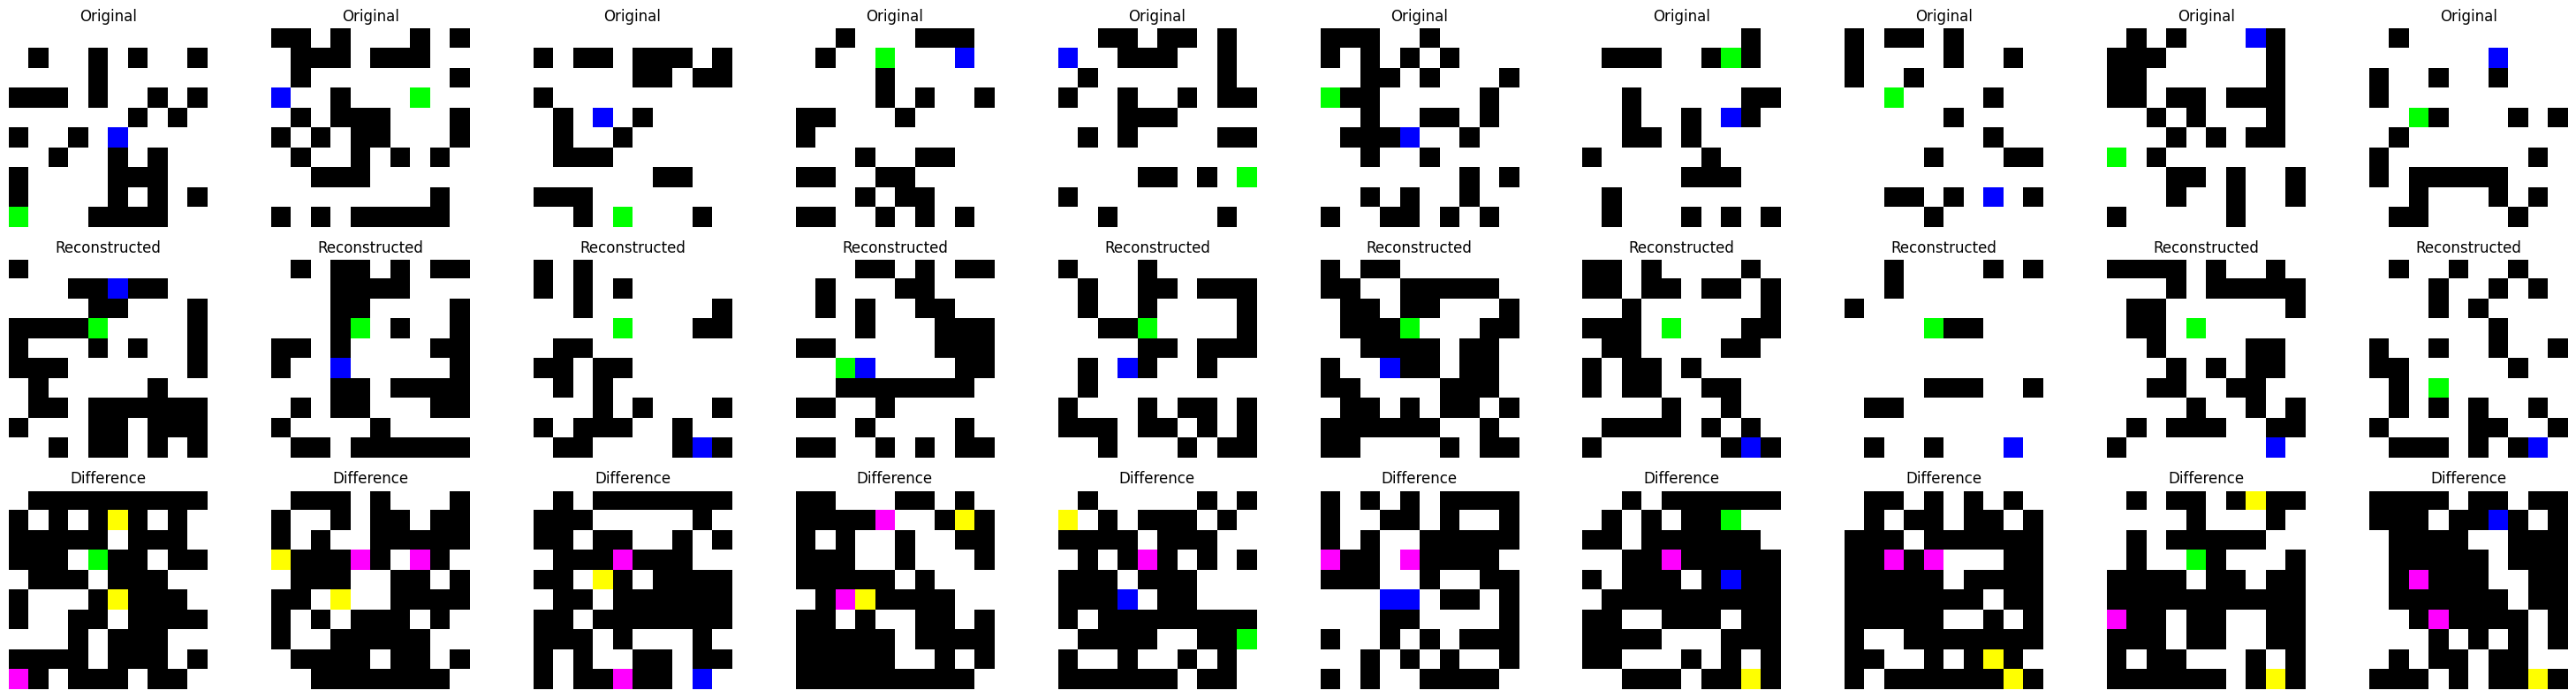

In [24]:
display_reconstruction(model=vae, dataset=dataset, device='cuda', visualize_fn=visualize_grid_world, num_samples=10)

In [25]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class MazeDataset(Dataset):
    def __init__(self, root):
        self.grid_dir = os.path.join(root, 'grid')
        self.path_length_dir = os.path.join(root, 'path_length')
        self.astar_dir = os.path.join(root, 'a_star_l2_results')

        self.indices = []

        for fname in os.listdir(self.grid_dir):
            if fname.endswith('.npy'):
                idx = fname.split('.')[0].split('_')[-1]
                path_file = f'path_length_{idx}.npy'
                astar_file = f'a_star_{idx}.npy'

                if os.path.exists(os.path.join(self.path_length_dir, path_file)) and \
                   os.path.exists(os.path.join(self.astar_dir, astar_file)):
                    self.indices.append(idx)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]

        # Load grid (maze)
        grid_path = os.path.join(self.grid_dir, f'maze_{idx}.npy')
        maze = np.load(grid_path)
        maze = torch.tensor(maze, dtype=torch.float32)  # assuming [H, W, 3]

        # Load scalar values
        path_length = np.load(os.path.join(self.path_length_dir, f'path_length_{idx}.npy')).item()
        a_star = np.load(os.path.join(self.astar_dir, f'a_star_{idx}.npy')).item()

        # Compute difficulty
        difficulty = a_star / (max(path_length, 1))
        difficulty = torch.tensor(difficulty, dtype=torch.float32)

        return maze, difficulty


In [26]:
import torch
import torch.nn as nn

class DiffusionModel(nn.Module):
    def __init__(self, latent_dim, cond_dim=1, num_steps=1000, beta_start=1e-4, beta_end=0.02):
        super(DiffusionModel, self).__init__()

        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.num_steps = num_steps  # Define num_steps here

        # Define the noise schedule
        self.betas = torch.linspace(beta_start, beta_end, num_steps)  # Linear betas
        self.alphas = 1.0 - self.betas  # Alpha = 1 - Beta
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)  # Cumulative product for alpha

        # Define your model network
        self.model = nn.Sequential(
            nn.Linear(latent_dim + cond_dim + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x, t, cond):
        """
        :param x: The latent vector at time step t (e.g., the noisy version)
        :param t: The current time step (integer)
        :param cond: The conditioning information (e.g., difficulty)
        """
        t = t.float().unsqueeze(1) / self.num_steps  # Normalize time step to [0, 1]
        input = torch.cat([x, cond, t], dim=1)  # Concatenate latent, condition, and time
        return self.model(input)


In [27]:
def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

class LatentDiffusionTrainer:
    def __init__(self, model, latent_dim, timesteps=1000, device='cuda'):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.device = device
        self.latent_dim = latent_dim

        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion: q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod = self.alpha_cumprod[t].sqrt().unsqueeze(1)
        sqrt_one_minus = (1 - self.alpha_cumprod[t]).sqrt().unsqueeze(1)
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus * noise

    def p_losses(self, x_start, cond, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        noise_pred = self.model(x_noisy, t, cond)
        return F.mse_loss(noise_pred, noise)

    def train_step(self, x, cond, optimizer):
        self.model.train()
        t = torch.randint(0, self.timesteps, (x.size(0),), device=x.device)
        loss = self.p_losses(x, cond, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()


In [28]:
from tqdm import tqdm

vae.eval()

def train_diffusion(model, trainer, dataloader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for grid, difficulty in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            grid = grid.to(torch.float32).to(trainer.device)
            mu, logvar = vae.encode(grid)
            latent = vae.reparameterize(mu, logvar)
            difficulty = difficulty.to(trainer.device).unsqueeze(1)  # [B, 1]
            loss = trainer.train_step(latent, difficulty, optimizer)
            total_loss += loss
        print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")


In [29]:
latent_dim = LATENT_DIM 
diffusionMLP = DiffusionModel(latent_dim)
trainer = LatentDiffusionTrainer(diffusionMLP, latent_dim, timesteps=1000)

maze_dataset = MazeDataset("/home/atul/diffusion-based-environment-generator/generator/data/")
diffusion_dataloader = torch.utils.data.DataLoader(maze_dataset, batch_size=64, shuffle=True)

train_diffusion(diffusionMLP, trainer, diffusion_dataloader, epochs=100)


Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 102.74it/s]


Epoch 1 Loss: 0.9824


Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 110.20it/s]


Epoch 2 Loss: 0.9083


Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 114.10it/s]


Epoch 3 Loss: 0.8047


Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 112.89it/s]


Epoch 4 Loss: 0.7192


Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 91.54it/s]


Epoch 5 Loss: 0.6526


Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 105.31it/s]


Epoch 6 Loss: 0.5980


Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 104.82it/s]


Epoch 7 Loss: 0.5542


Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 108.52it/s]


Epoch 8 Loss: 0.5166


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 108.99it/s]


Epoch 9 Loss: 0.4888


Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 113.69it/s]


Epoch 10 Loss: 0.4727


Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 112.24it/s]


Epoch 11 Loss: 0.4393


Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 111.54it/s]


Epoch 12 Loss: 0.4323


Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 97.58it/s] 


Epoch 13 Loss: 0.4249


Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 113.21it/s]


Epoch 14 Loss: 0.4082


Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 115.31it/s]


Epoch 15 Loss: 0.3982


Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 110.78it/s]


Epoch 16 Loss: 0.3891


Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 107.01it/s]


Epoch 17 Loss: 0.3811


Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 105.92it/s]


Epoch 18 Loss: 0.3779


Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 107.83it/s]


Epoch 19 Loss: 0.3798


Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 109.32it/s]


Epoch 20 Loss: 0.3798


Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 106.32it/s]


Epoch 21 Loss: 0.3680


Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 108.70it/s]


Epoch 22 Loss: 0.3678


Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 111.21it/s]


Epoch 23 Loss: 0.3673


Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 110.07it/s]


Epoch 24 Loss: 0.3718


Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 112.55it/s]


Epoch 25 Loss: 0.3558


Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 108.88it/s]


Epoch 26 Loss: 0.3616


Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 104.10it/s]


Epoch 27 Loss: 0.3528


Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


Epoch 28 Loss: 0.3668


Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 108.81it/s]


Epoch 29 Loss: 0.3638


Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 105.05it/s]


Epoch 30 Loss: 0.3643


Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 94.97it/s] 


Epoch 31 Loss: 0.3640


Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 108.05it/s]


Epoch 32 Loss: 0.3595


Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 102.96it/s]


Epoch 33 Loss: 0.3593


Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 104.15it/s]


Epoch 34 Loss: 0.3523


Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 107.34it/s]


Epoch 35 Loss: 0.3529


Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 97.63it/s] 


Epoch 36 Loss: 0.3583


Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 95.04it/s]


Epoch 37 Loss: 0.3502


Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 104.80it/s]


Epoch 38 Loss: 0.3566


Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 103.87it/s]


Epoch 39 Loss: 0.3496


Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 105.29it/s]


Epoch 40 Loss: 0.3544


Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 103.99it/s]


Epoch 41 Loss: 0.3463


Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 101.18it/s]


Epoch 42 Loss: 0.3541


Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 102.92it/s]


Epoch 43 Loss: 0.3569


Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 93.02it/s]


Epoch 44 Loss: 0.3479


Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 89.96it/s] 


Epoch 45 Loss: 0.3516


Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 105.92it/s]


Epoch 46 Loss: 0.3439


Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 104.97it/s]


Epoch 47 Loss: 0.3400


Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 94.81it/s] 


Epoch 48 Loss: 0.3484


Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 107.03it/s]


Epoch 49 Loss: 0.3497


Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 104.80it/s]


Epoch 50 Loss: 0.3484


Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 105.96it/s]


Epoch 51 Loss: 0.3441


Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


Epoch 52 Loss: 0.3470


Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 107.55it/s]


Epoch 53 Loss: 0.3501


Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 107.50it/s]


Epoch 54 Loss: 0.3529


Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 104.78it/s]


Epoch 55 Loss: 0.3428


Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 97.74it/s]


Epoch 56 Loss: 0.3498


Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 90.75it/s] 


Epoch 57 Loss: 0.3423


Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 103.86it/s]


Epoch 58 Loss: 0.3485


Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 123.84it/s]


Epoch 59 Loss: 0.3416


Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 119.08it/s]


Epoch 60 Loss: 0.3412


Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 101.27it/s]


Epoch 61 Loss: 0.3413


Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 103.96it/s]


Epoch 62 Loss: 0.3416


Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 103.69it/s]


Epoch 63 Loss: 0.3414


Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 86.13it/s]


Epoch 64 Loss: 0.3422


Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 89.84it/s]


Epoch 65 Loss: 0.3432


Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 82.14it/s]


Epoch 66 Loss: 0.3386


Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 94.22it/s] 


Epoch 67 Loss: 0.3407


Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 91.16it/s] 


Epoch 68 Loss: 0.3381


Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 92.30it/s]


Epoch 69 Loss: 0.3430


Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s] 


Epoch 70 Loss: 0.3467


Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 95.07it/s]


Epoch 71 Loss: 0.3395


Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 98.89it/s] 


Epoch 72 Loss: 0.3468


Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 93.32it/s]


Epoch 73 Loss: 0.3428


Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


Epoch 74 Loss: 0.3439


Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 106.22it/s]


Epoch 75 Loss: 0.3372


Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 105.39it/s]


Epoch 76 Loss: 0.3340


Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 102.20it/s]


Epoch 77 Loss: 0.3389


Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 105.99it/s]


Epoch 78 Loss: 0.3348


Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 103.72it/s]


Epoch 79 Loss: 0.3348


Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 103.11it/s]


Epoch 80 Loss: 0.3380


Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 107.65it/s]


Epoch 81 Loss: 0.3374


Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 100.93it/s]


Epoch 82 Loss: 0.3447


Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 97.39it/s] 


Epoch 83 Loss: 0.3361


Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 90.49it/s] 


Epoch 84 Loss: 0.3415


Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 98.11it/s] 


Epoch 85 Loss: 0.3399


Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 98.56it/s] 


Epoch 86 Loss: 0.3342


Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 103.61it/s]


Epoch 87 Loss: 0.3363


Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 102.84it/s]


Epoch 88 Loss: 0.3361


Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 102.14it/s]


Epoch 89 Loss: 0.3388


Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 104.09it/s]


Epoch 90 Loss: 0.3399


Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 103.41it/s]


Epoch 91 Loss: 0.3313


Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 107.57it/s]


Epoch 92 Loss: 0.3353


Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


Epoch 93 Loss: 0.3396


Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 108.36it/s]


Epoch 94 Loss: 0.3393


Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 109.84it/s]


Epoch 95 Loss: 0.3334


Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 105.90it/s]


Epoch 96 Loss: 0.3317


Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 107.37it/s]


Epoch 97 Loss: 0.3313


Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 111.71it/s]


Epoch 98 Loss: 0.3318


Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


Epoch 99 Loss: 0.3319


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 103.98it/s]

Epoch 100 Loss: 0.3282


In [30]:
def sample_from_diffusion(diffusion_model, vae, difficulty, latent_dim, device='cuda'):
    diffusion_model.eval()
    vae.eval()

    # Start from random noise in latent space
    x = torch.randn(1, latent_dim).to(device)  # shape [1, latent_dim]
    cond = difficulty.view(1, 1).to(device)    # shape [1, 1]

    # Run diffusion sampling loop (reverse process)
    for t in reversed(range(diffusion_model.num_steps)):
        t_tensor = torch.full((1,), t, dtype=torch.long, device=device)
        eps_theta = diffusion_model(x, t_tensor, cond)
        alpha_t = diffusion_model.alphas[t]
        alpha_bar_t = diffusion_model.alpha_bars[t]
        beta_t = diffusion_model.betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha_t)) * (
            x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta
        ) + torch.sqrt(beta_t) * noise

    # Decode the final latent vector into a maze
    with torch.no_grad():
        recon = vae.decode(x).view(1, 10, 10, 3).cpu()
        discrete_struct = vae.predict_discrete_structure(recon).squeeze(0).cpu().numpy()

    return discrete_struct


In [ ]:
def visualize_sample(sample, difficulty):
    img = visualize_grid_world(sample)
    plt.imshow(img)
    plt.title(f"Sampled Maze — Difficulty {difficulty.item():.2f}")
    plt.axis('off')
    plt.show()


tensor([[[0.6573, 0.4743, 0.7238, 0.8655, 0.6143, 0.7014, 0.7699, 0.3276,
          0.8402, 0.7250],
         [0.6922, 0.4255, 0.7058, 0.7224, 0.5550, 0.7517, 0.7193, 0.5754,
          0.3712, 0.6769],
         [0.7139, 0.5999, 0.5079, 0.7673, 0.4894, 0.1657, 0.7121, 0.3629,
          0.6045, 0.5260],
         [0.4516, 0.3336, 0.5396, 0.6426, 0.6129, 0.3761, 0.5220, 0.4178,
          0.5002, 0.3500],
         [0.1370, 0.6303, 0.6934, 0.3705, 0.4403, 0.5844, 0.1792, 0.6814,
          0.2193, 0.6322],
         [0.4285, 0.3303, 0.5412, 0.5420, 0.2881, 0.3643, 0.5059, 0.5741,
          0.5010, 0.5693],
         [0.3734, 0.4285, 0.8278, 0.9506, 0.8689, 0.4791, 0.8593, 0.4656,
          0.9200, 0.9325],
         [0.6339, 0.5389, 0.5995, 0.2505, 0.8699, 0.2997, 0.2889, 0.8404,
          0.4331, 0.7506],
         [0.2771, 0.3609, 0.7236, 0.5842, 0.6044, 0.5544, 0.5832, 0.9617,
          0.7015, 0.5327],
         [0.7261, 0.7235, 0.3506, 0.4712, 0.7398, 0.6218, 0.7520, 0.2050,
          0.4280,

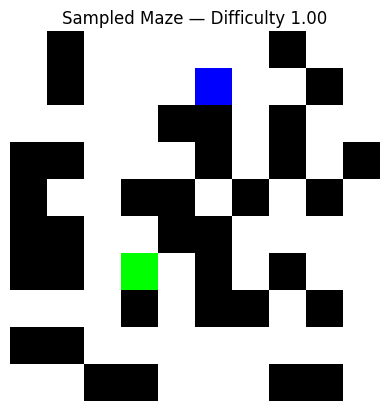

In [40]:
difficulty = torch.tensor([1.0])  # Or any difficulty level you want
sampled_maze = sample_from_diffusion(diffusionMLP, vae, difficulty, latent_dim=vae.latent_dim)
visualize_sample(sampled_maze, difficulty)